# Projet Machine Learning
#### Présenté par:
### Yarame BA et Awa SENE

## Introduction du projet

L’objectif principal de ce projet est de développer un modèle de prédiction capable d’estimer avec précision la température à un instant donné, en se basant sur d’autres paramètres météorologiques disponibles. L’accent est mis sur la précision des prédictions à court terme : +1h, +4h et +10h.

Une bonne solution repose sur deux piliers :
- Une **précision élevée** (écart faible entre température prédite et réelle, faible RMSE, R² proche de 1) ;
- Une **généralisation correcte** sur des données jamais vues (validation croisée fiable).

### Méthodologie :
Nous suivons les étapes suivantes :
1. **Analyse exploratoire** des données ;
2. **Prétraitement**, extraction de variables temporelles, et nettoyage ;
3. **Sélection d’un modèle robuste** (Random Forest) ;
4. **Évaluation des performances** (train/test + validation croisée) ;
5. **Optimisation du pipeline** pour une utilisation future.

### Intuitions de départ :
La température dépend de nombreux facteurs : humidité, vent, heure du jour, saison… Ces effets peuvent être non linéaires. Nous avons choisi d’extraire des composantes temporelles cycliques (heure et mois) à partir de la colonne "Date/Heure", et d’utiliser un **modèle d’ensemble basé sur les arbres** (Random Forest) pour capturer ces relations complexes.


# Description et discussion sur les données
## Description des données

Le jeu de données contient des mesures météorologiques collectées à différentes heures. Les colonnes principales sont :

- `Date/Heure` : horodatage des relevés (converti en `datetime`) ;
- `temperature_2m` : température cible à 2 mètres (à prédire) ;
- `Humidité_relative` : humidité de l’air ;
- `Vitesse_vent_10m` : vitesse du vent à 10 mètres ;
- `evapotranspiration` : taux combiné d’évaporation et de transpiration.

### Objectif :
Prédire `temperature_2m` à trois horizons : +1h, +4h et +10h.

### Analyse des attributs :
- Données principalement numériques ;
- Extraction des composantes **heure/mois** depuis la date ;
- Transformation en **variables cycliques** (`sin`, `cos`) pour tenir compte de la périodicité.

### Visualisation :
- Histogrammes : distribution normale pour la température, plus hétérogène pour humidité et vent ;
- Boxplots : quelques valeurs extrêmes détectées.

### Problèmes rencontrés :
1. **Outliers** : corrigés via la médiane (humidité, vent, evapotranspiration).
2. **Corrélations** : température ↔ humidité (négative) ; exploité dans la sélection des variables.
3. **Données temporelles** : transformation cyclique de l’heure et du mois.
4. **Dimensionalité** : légèrement augmentée avec les variables dérivées, mais gérée efficacement par Random Forest.

### Données manquantes utiles :
Certaines variables absentes pourraient améliorer la précision :
- Pression atmosphérique,
- Rayonnement solaire,
- Couverture nuageuse,
- Indice UV.

Ces données peuvent être intégrées via :
- APIs météo (OpenWeatherMap, WeatherAPI),
- Données satellites (NASA POWER, Copernicus),
- Centres météo nationaux.


## Prétraitement appliqué

Les étapes de traitement des données sont :

1. **Nettoyage des valeurs aberrantes** : remplacement par la médiane.
2. **Extraction de variables temporelles** : heure et mois depuis la date.
3. **Transformation cyclique** : `hour_sin`, `hour_cos`, `month_sin`, `month_cos`.
4. **Création des cibles décalées** : température à +1h, +4h, +10h.
5. **Normalisation des variables** : avec `StandardScaler`.

Les données sont ensuite stockées dans un DataFrame `pandas`, puis séparées en `X` (features) et `y` (targets) pour chaque horizon.


## Choix de l’algorithme : Random Forest Regressor

### Pourquoi ce choix ?
- Gère très bien les **interactions non linéaires** ;
- **Robuste aux valeurs extrêmes** et au bruit ;
- **Facile à implémenter**, performant même sans réglage fin ;
- **Adapté aux ensembles de variables hétérogènes** (temporelles, climatiques).

### Fonctionnement :
- Basé sur le **Bagging** : chaque arbre est entraîné sur un sous-échantillon avec remise ;
- Sélection aléatoire de variables à chaque split ;
- Moyenne des prédictions des arbres pour la sortie finale.

### Alternatives considérées :
- **Régression linéaire** : trop limitée pour les phénomènes climatiques ;
- **KNN** : sensible à la dimensionnalité et à la normalisation ;
- **Gradient Boosting** : plus complexe à ajuster, plus lent.

Random Forest offre un excellent compromis entre **précision**, **simplicité**, et **robustesse**.


## 1. Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Importation des données

In [ ]:
# Étape 2 : Uploader le fichier 
from google.colab import files
uploaded = files.upload()

# Étape 3 : Lire le fichier 
df = pd.read_csv("Climat_Données_sn.csv")

Saving Climat_Données_sn.csv to Climat_Données_sn.csv


## 3. Renommage des colonnes

In [3]:
df.columns = [
    "Date/Heure",
    "temperature_2m",
    "Humidité_relative",
    "Vitesse_vent_10m",
    "evapotranspiration"
]

## 4.Affichage des premières lignes

In [4]:
print(df.head())

         Date/Heure  temperature_2m  Humidité_relative  Vitesse_vent_10m  \
0  2010-01-01 00:00            23.4                 36               8.7   
1  2010-01-01 01:00            21.9                 39               9.5   
2  2010-01-01 02:00            20.7                 41              10.4   
3  2010-01-01 03:00            19.7                 41               9.4   
4  2010-01-01 04:00            19.0                 40               8.3   

   evapotranspiration  
0                0.08  
1                0.08  
2                0.08  
3                0.07  
4                0.07  


## 5. Vérification des types

In [5]:
print(df.dtypes)

Date/Heure             object
temperature_2m        float64
Humidité_relative       int64
Vitesse_vent_10m      float64
evapotranspiration    float64
dtype: object


##  6. Résumé statistique

In [6]:
print(df.describe(include='all'))

              Date/Heure  temperature_2m  Humidité_relative  Vitesse_vent_10m  \
count              87648    87648.000000       87648.000000      87648.000000   
unique             87648             NaN                NaN               NaN   
top     2019-12-31 07:00             NaN                NaN               NaN   
freq                   1             NaN                NaN               NaN   
mean                 NaN       28.877529          42.833208         10.383053   
std                  NaN        5.442238          26.256020          3.778295   
min                  NaN       12.400000           3.000000          0.000000   
25%                  NaN       25.000000          20.000000          7.900000   
50%                  NaN       28.300000          35.000000         10.200000   
75%                  NaN       32.800000          64.000000         13.000000   
max                  NaN       45.600000         100.000000         28.100000   

        evapotranspiration 

## 7. Vérification des valeurs manquantes

In [7]:
def proportion_valeurs_manquantes(data):
    nb_valeurs_manquantes = data.isna().sum()
    proportion_manquantes = nb_valeurs_manquantes / len(data)
    return pd.DataFrame({'Nombre': nb_valeurs_manquantes, 'Proportion': proportion_manquantes})

manquantes = proportion_valeurs_manquantes(df)
print(manquantes)

                    Nombre  Proportion
Date/Heure               0         0.0
temperature_2m           0         0.0
Humidité_relative        0         0.0
Vitesse_vent_10m         0         0.0
evapotranspiration       0         0.0


## 8. Analyse univariée : Histogrammes

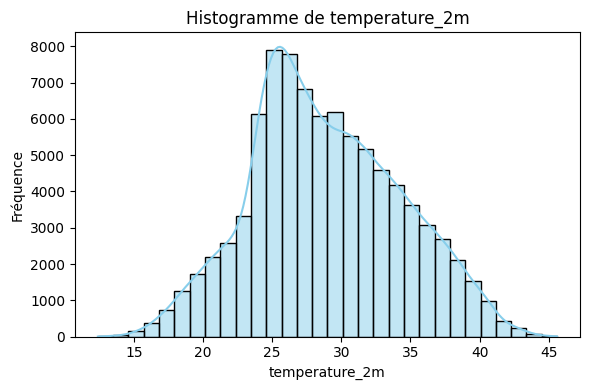

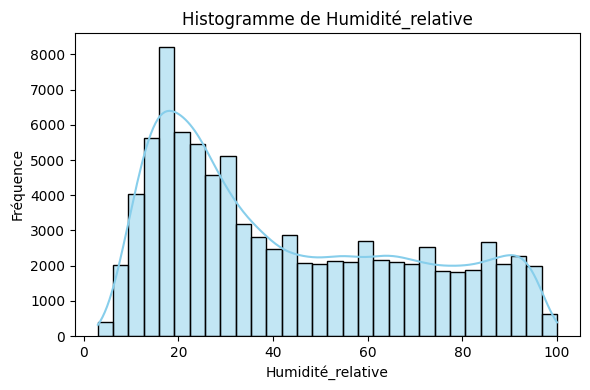

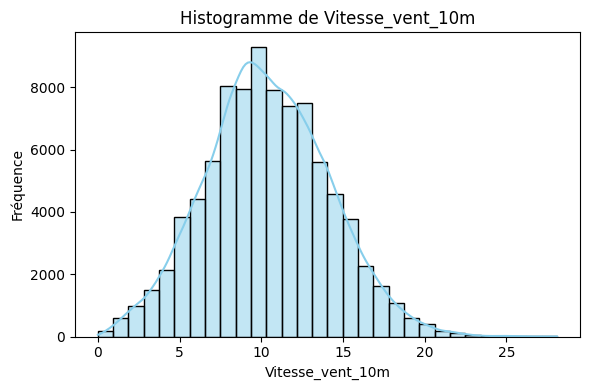

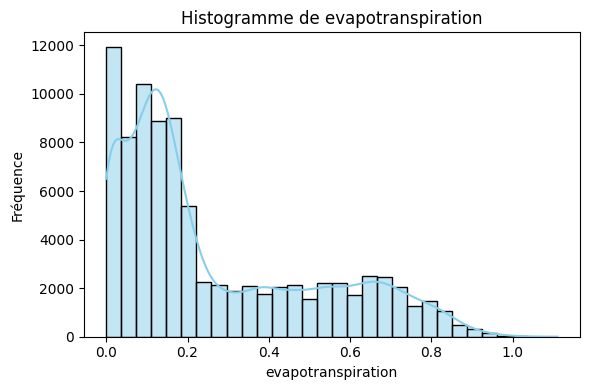

In [8]:
# 9. Analyse univariée (Histogrammes des variables numériques)
variables_numeriques = df.select_dtypes(include=[np.number]).columns

for col in variables_numeriques:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogramme de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.tight_layout()
    plt.show()

## Analyse des histogrammes
- `temperature_2m`: Distribution quasi normale centrée autour de 25-26°C. Bien répartie, adaptée à la régression sans transformation.

- `Humidité_relative` : Forte asymétrie à droite, pic vers 18-20%. Valeurs très concentrées dans les faibles humidités. Une transformation pourrait être utile.

- `Vitesse_vent_10m` : Distribution légèrement asymétrique à droite, pic vers 10 m/s. Variable stable et exploitable telle quelle.

- `evapotranspiration` : Très asymétrique avec un pic proche de 0. Majorité des valeurs faibles. Transformation recommandée.

Conclusion : Les variables ont des distributions variées. Certaines nécessitent un prétraitement pour améliorer les performances des modèles.

## 9. Analyse bivariée : Matrice de corrélation

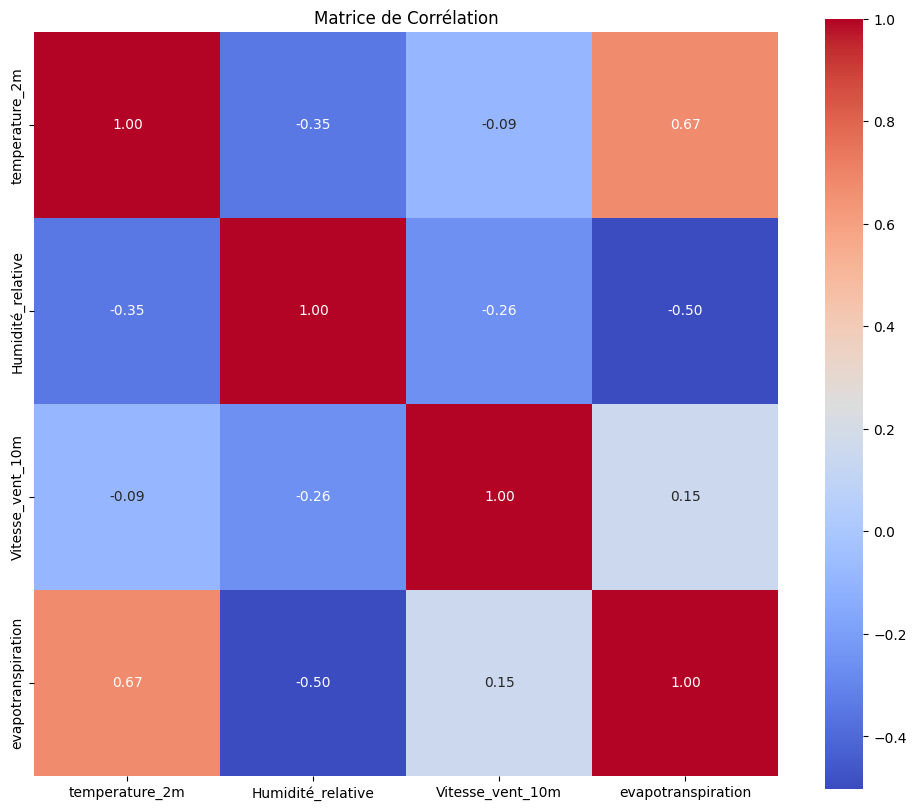

In [9]:
plt.figure(figsize=(12,10))
correlation = df[variables_numeriques].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Matrice de Corrélation')
plt.show()

## Matrice de Corrélation — Interprétation
Ce graphique représente les corrélations linéaires (coefficients de Pearson) entre les variables numériques du dataset. Les valeurs vont de -1 (corrélation négative parfaite) à +1 (corrélation positive parfaite).
- `temperature_2m ↔ evapotranspiration` :Corrélation positive forte (+0.67) → plus il fait chaud, plus l’évaporation est importante.
- `Humidité_relative ↔ evapotranspiration` :Corrélation négative modérée (–0.50) → l’évaporation diminue quand l’air est très humide.
- `temperature_2m ↔ Humidité_relative` :Corrélation négative faible à modérée (–0.35) → plus il fait chaud, moins l’air est humide.
- `Vitesse_vent_10m` :Corrélations faibles avec les autres variables → influence limitée dans ce jeu de données.

## 10. Visualisation des valeurs aberrantes (Boxplots)

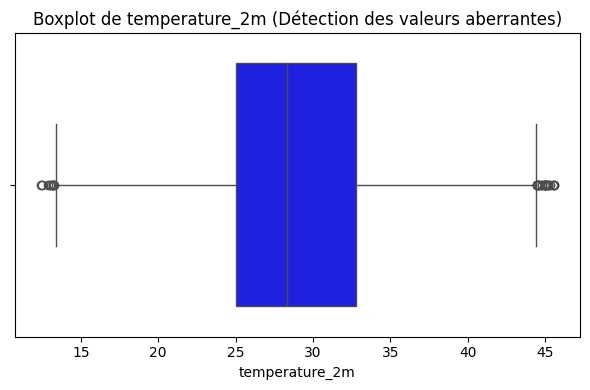

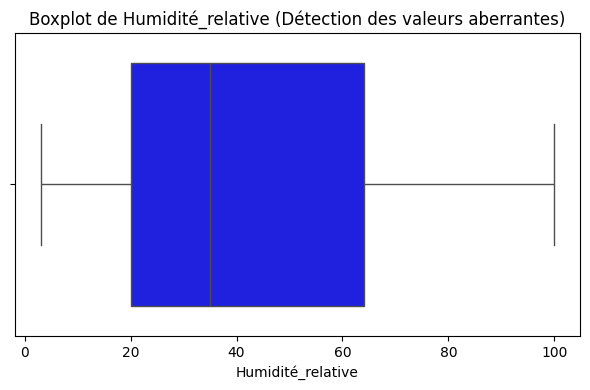

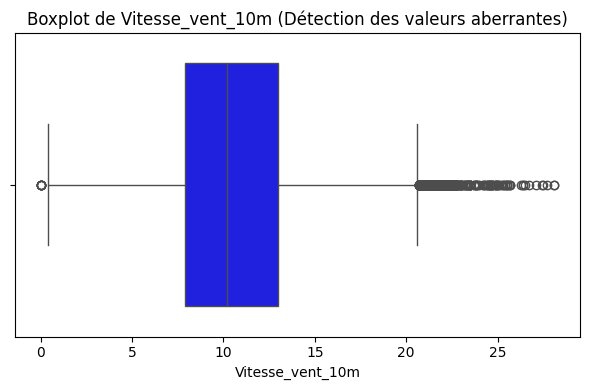

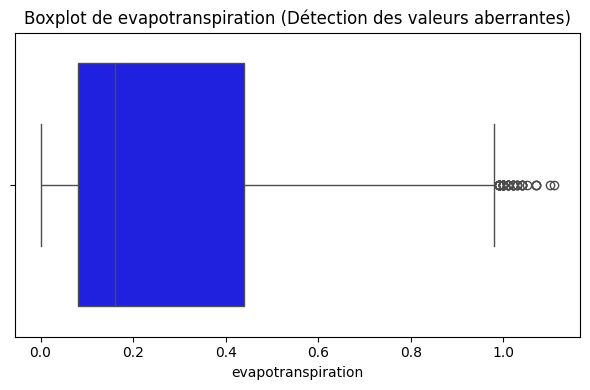

In [10]:
for col in variables_numeriques:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='blue')
    plt.title(f'Boxplot de {col} (Détection des valeurs aberrantes)')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## 11.Convertir la colonne Date/Heure en datetime

In [11]:
df["Date/Heure"] = pd.to_datetime(df["Date/Heure"])

## 12.Remplacer les valeurs aberrantes par la médiane

In [12]:
# Vérification des valeurs aberrantes (sauf température qui est correcte)
cols_to_check = ['Humidité_relative', 'Vitesse_vent_10m', 'evapotranspiration']
for col in cols_to_check:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    # Remplacer les valeurs aberrantes par la médiane
    median_val = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_val, df[col])

## 13.Définition des variables cycliques

In [13]:
# Variables cycliques
df["month"] = df["Date/Heure"].dt.month
df["hour"] = df["Date/Heure"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

## 14.Cibles futures

In [14]:
df["Temp_1h"] = df["temperature_2m"].shift(-1)
df["Temp_4h"] = df["temperature_2m"].shift(-4)
df["Temp_10h"] = df["temperature_2m"].shift(-10)
df.dropna(inplace=True)

## 15.Définition des features et targets

In [15]:
# Sélection des features SANS évapotranspiration
features = ["temperature_2m", "Humidité_relative", "Vitesse_vent_10m",
            "hour_sin", "hour_cos", "month_sin", "month_cos"]
targets = ["Temp_1h", "Temp_4h", "Temp_10h"]

## 16.Normalisation

In [16]:
# Normalisation
X = df[features]
y = df[targets]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 17.Cross validation

In [17]:
from sklearn.model_selection import cross_val_score, KFold

# Définir le modèle
model_cv = RandomForestRegressor(n_estimators=100, random_state=42)

# Définir le schéma de validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Attention : cross_val_score ne supporte pas directement les y multivariés
# Donc on fait une boucle pour chaque cible

for i, col in enumerate(targets):
    scores = cross_val_score(model_cv, X_scaled, y[col], cv=cv, scoring='r2')
    print(f"R² pour la variable cible {col} :")
    print(f"Scores par fold : {scores}")
    print(f"Score moyen : {scores.mean():.2f}")
    print("-" * 40)


R² pour la variable cible Temp_1h :
Scores par fold : [0.99234248 0.99200272 0.9921013  0.99228754 0.99198477]
Score moyen : 0.99
----------------------------------------
R² pour la variable cible Temp_4h :
Scores par fold : [0.96399511 0.96304527 0.96319983 0.96358052 0.96293375]
Score moyen : 0.96
----------------------------------------
R² pour la variable cible Temp_10h :
Scores par fold : [0.93203341 0.92769787 0.93143039 0.92916362 0.93060254]
Score moyen : 0.93
----------------------------------------


## Résultats du modèle (R² – Random Forest)
- `Température à +1h` : R² = 0.99
Précision excellente — le modèle explique 99 % de la variance.

- `Température à +4h` : R² = 0.96
Très bon score, légère baisse de précision à moyen terme.

- `Température à +10h` : R² = 0.93
Bonne performance, mais impact visible du délai sur la précision.

Conclusion : Le modèle est très performant, surtout à court terme. La qualité des prédictions diminue légèrement avec l’horizon, mais reste élevée.

## 18. Entrainement du modele

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 19.Sauvegarde

In [19]:
# Sauvegarde
joblib.dump(model, "modele_temperature_rf.pkl")
joblib.dump(scaler, "scaler_rf.pkl")


['scaler_rf.pkl']

## 20.Fonction de prédiction

In [20]:
def predict_temperature(date_str, humidite, vent, temp_actuelle):
    model = joblib.load("modele_temperature_rf.pkl")
    scaler = joblib.load("scaler_rf.pkl")

    date_obj = pd.to_datetime(date_str)
    hour = date_obj.hour
    month = date_obj.month

    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    input_data = pd.DataFrame([[temp_actuelle, humidite, vent,
                                hour_sin, hour_cos, month_sin, month_cos]],
                                columns=features)

    input_scaled = scaler.transform(input_data)
    pred = model.predict(input_scaled)[0]

    return {
        "+1h": round(pred[0], 1),
        "+4h": round(pred[1], 1),
        "+10h": round(pred[2], 1)
    }


## 21. Prédiction sur les données de test

In [21]:
# Prédictions sur le test set
y_pred = model.predict(X_test)
# Évaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Évaluation du modèle :")
print(f"MSE : {mse:.2f}")
print(f"RMSE : {np.sqrt(mse):.2f}")
print(f"MAE : {mae:.2f}")
print(f"R² : {r2:.2f}")

Évaluation du modèle :
MSE : 1.16
RMSE : 1.08
MAE : 0.72
R² : 0.96


## Interprétations des prédictions
Les résultats montrent que le modèle fonctionne très bien. L’erreur moyenne (MAE) entre les prédictions et les vraies valeurs est d’environ 0.72, ce qui veut dire que le modèle se trompe en moyenne de moins d’une unité. L’erreur un peu plus sensible aux grandes différences (RMSE) est de 1.08, ce qui reste faible. L’erreur quadratique moyenne (MSE), qui pénalise davantage les grosses erreurs, est aussi faible : 1.16.

Mais surtout, le score R² est de 0.96, ce qui veut dire que 96 % des variations des données sont bien expliquées par le modèle. Autrement dit, le modèle reproduit très bien les données et fait peu d’erreurs.

En résumé : le modèle est précis, fait peu d’erreurs, et explique très bien ce qu’il essaie de prédire.



## 22. Rapport RMSE / moyenne

In [22]:
print("Rapport RMSE / Moyenne (plus c'est bas, mieux c'est) :\n")

for i, col in enumerate(targets):
    moyenne = y_test[col].mean()
    rmse_model = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    rapport = rmse_model / moyenne
    print(f"{col} : RMSE = {rmse_model:.2f}, Moyenne = {moyenne:.2f}, Rapport = {rapport:.2f}")


Rapport RMSE / Moyenne (plus c'est bas, mieux c'est) :

Temp_1h : RMSE = 0.48, Moyenne = 28.88, Rapport = 0.02
Temp_4h : RMSE = 1.04, Moyenne = 28.88, Rapport = 0.04
Temp_10h : RMSE = 1.47, Moyenne = 28.89, Rapport = 0.05


## Interprétation Rapport RMSE / moyenne
Le "rapport RMSE / moyenne" donne une information complémentaire importante à l’évaluation du modèle : il met l’erreur (RMSE) en perspective avec la grandeur des valeurs que l’on essaie de prédire. Ce qu’on appelle ici le "rapport RMSE / moyenne" permet de savoir à quel point l’erreur est importante par rapport à l’échelle des données.
 `Temp_1h` : Le modèle est très précis à 1h d’échéance. L’erreur représente à peine 2 % de la température moyenne.

 `Temp_4h` : L’erreur monte un peu, mais reste faible : 4 % de la moyenne.

 `Temp_10h` : L’erreur est plus élevée (logique avec l’échéance qui augmente), mais reste faible aussi : 5 % de la moyenne.

## 23. Test

In [23]:
resultats = predict_temperature(
    date_str="2025-04-12 21:20",
    humidite=81,
    vent=9.1,
    temp_actuelle=21.0
)

print("\nTempératures prévues :")
for h, t in resultats.items():
    print(f"{h} ➜ {t} °C")



Températures prévues :
+1h ➜ 21.3 °C
+4h ➜ 19.6 °C
+10h ➜ 17.7 °C


## 24. Analyse qualitative des performances

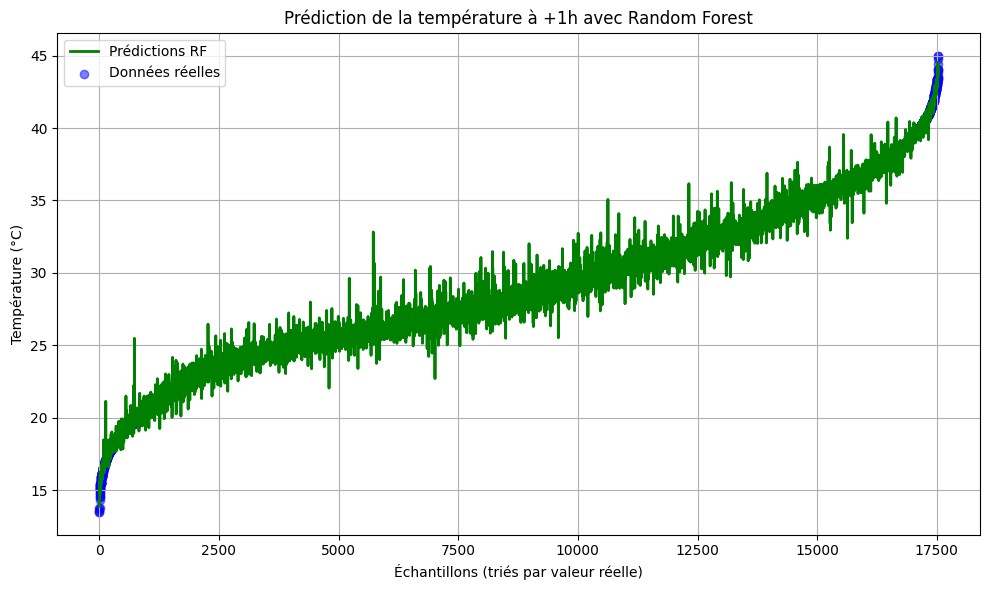

In [24]:
# Choisir la cible à visualiser
target_col = 'Temp_1h'

# Récupération des vraies valeurs et prédictions
y_true = y_test[target_col].values
y_pred_1h = y_pred[:, 0]  # 0 = Temp_1h

# Tri pour tracer une courbe propre
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred_1h[sorted_idx]

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, color='green', linewidth=2, label='Prédictions RF')
plt.scatter(range(len(y_true_sorted)), y_true_sorted, color='blue', alpha=0.5, label='Données réelles')
plt.title("Prédiction de la température à +1h avec Random Forest")
plt.xlabel("Échantillons (triés par valeur réelle)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

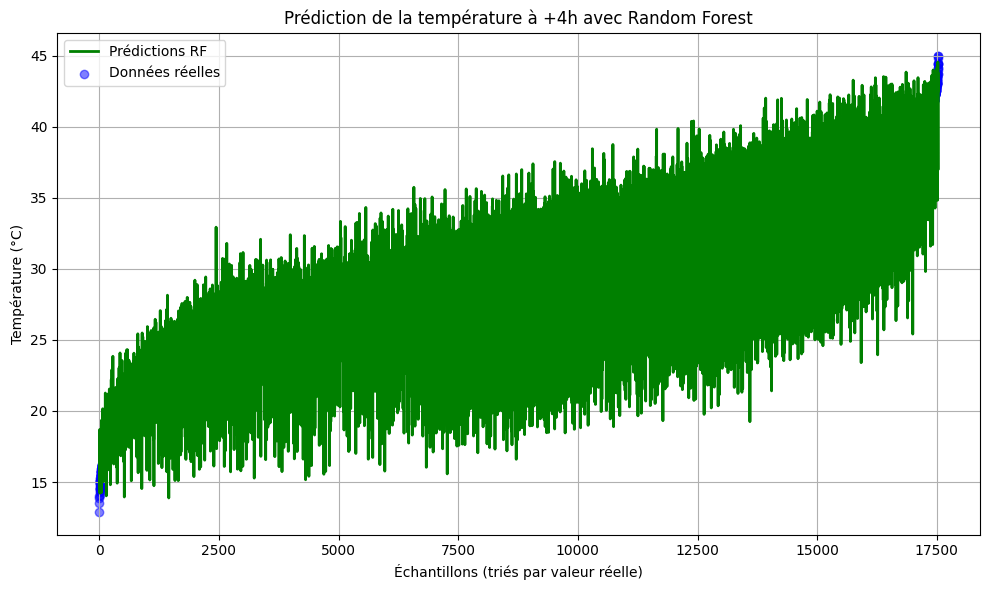

In [25]:
# Choisir la cible à visualiser
target_col = 'Temp_4h'

# Récupération des vraies valeurs et prédictions
y_true = y_test[target_col].values
y_pred_1h = y_pred[:, 0]  # 0 = Temp_1h

# Tri pour tracer une courbe propre
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred_1h[sorted_idx]

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, color='green', linewidth=2, label='Prédictions RF')
plt.scatter(range(len(y_true_sorted)), y_true_sorted, color='blue', alpha=0.5, label='Données réelles')
plt.title("Prédiction de la température à +4h avec Random Forest")
plt.xlabel("Échantillons (triés par valeur réelle)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

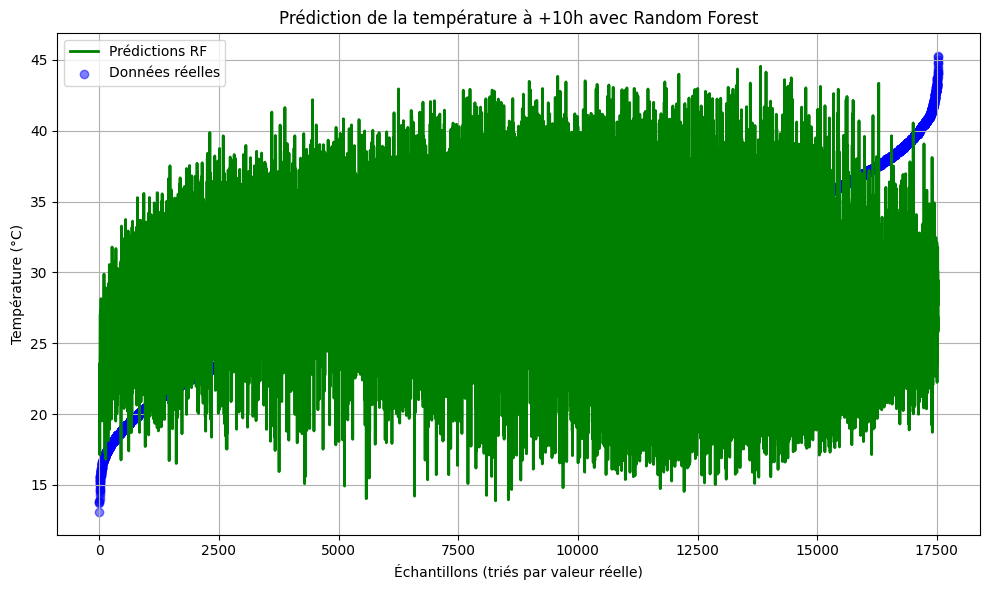

In [26]:
# Choisir la cible à visualiser
target_col = 'Temp_10h'

# Récupération des vraies valeurs et prédictions
y_true = y_test[target_col].values
y_pred_1h = y_pred[:, 0]  # 0 = Temp_1h

# Tri pour tracer une courbe propre
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred_1h[sorted_idx]

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, color='green', linewidth=2, label='Prédictions RF')
plt.scatter(range(len(y_true_sorted)), y_true_sorted, color='blue', alpha=0.5, label='Données réelles')
plt.title("Prédiction de la température à +10h avec Random Forest")
plt.xlabel("Échantillons (triés par valeur réelle)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interprétation des figures

#### 1. **+1h (Temp_1h)**
- **Courbe verte (prédictions)** : suit de très près les points bleus (valeurs réelles), avec peu de dispersion.
- **Erreur faible** : les écarts entre prédiction et réalité sont minimes.
- Cela confirme une **très bonne performance** du modèle à court terme.

#### 2. **+4h (Temp_4h)**
- **Tendance encore correcte**, mais :
  - **Plus de dispersion verticale** : les prédictions s’éloignent davantage des vraies valeurs.
  - **Erreur plus visible** : le modèle commence à perdre en précision.
- Le modèle reste **globalement bon**, mais l'incertitude **augmente** avec l'horizon de prédiction.

#### 3. **+10h (Temp_10h)**
- **Énorme dispersion verticale** des prédictions.
- Les prédictions (ligne verte) deviennent **quasi plates** au centre, alors que les valeurs réelles (points bleus) varient beaucoup.
- Le modèle ne parvient plus à capter correctement la dynamique de température **au-delà de 10h**. Il **sature** ou **baisse en généralisation**.

---

### Conclusion

- **Prédiction à court terme (+1h)** : excellente — les prédictions sont proches des observations réelles.
- **Prédiction à moyen terme (+4h)** : satisfaisante, mais la précision commence à diminuer.
- **Prédiction à long terme (+10h)** : le modèle perd en capacité à prédire avec précision, probablement à cause :
  - d’une **perte d'information utile avec le temps**,
  - de la **complexité croissante** de la dynamique météo,
  - ou du **manque de signaux forts** à longue échéance dans les données d’entrée.


## 25.Statistiques détaillées

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, mean_absolute_error, mean_squared_error
import time
import numpy as np

SEUIL_TOLERANCE = 1.5  # ±1.5°C

# Initialisation
stats = {}

# Mesure du temps de calcul
start_time = time.time()

for i, col in enumerate(targets):
    y_true_col = y_test[col].values
    y_pred_col = y_pred[:, i]

    succes = np.abs(y_true_col - y_pred_col) <= SEUIL_TOLERANCE
    taux_succes = np.mean(succes)

    y_true_binaire = np.ones_like(y_true_col)  # tous les vrais labels sont 1
    y_pred_binaire = succes.astype(int)        # prédiction binaire (succès ou non)

    precision = precision_score(y_true_binaire, y_pred_binaire)
    recall = recall_score(y_true_binaire, y_pred_binaire)

    stats[col] = {
        "Taux de succès": taux_succes,
        "Précision": precision,
        "Rappel": recall,
        "MAE": mean_absolute_error(y_true_col, y_pred_col),
        "RMSE": np.sqrt(mean_squared_error(y_true_col, y_pred_col))
    }

end_time = time.time()
temps_total = end_time - start_time

# Résultats
print("Statistiques détaillées par échéance :")
for cible, metriques in stats.items():
    print(f"\nCible : {cible}")
    for k, v in metriques.items():
        print(f"  {k} : {v:.3f}")

print(f"\nTemps de calcul : {temps_total:.3f} secondes")


Statistiques détaillées par échéance :

Cible : Temp_1h
  Taux de succès : 0.984
  Précision : 1.000
  Rappel : 0.984
  MAE : 0.310
  RMSE : 0.480

Cible : Temp_4h
  Taux de succès : 0.877
  Précision : 1.000
  Rappel : 0.877
  MAE : 0.753
  RMSE : 1.043

Cible : Temp_10h
  Taux de succès : 0.744
  Précision : 1.000
  Rappel : 0.744
  MAE : 1.103
  RMSE : 1.471

Temps de calcul : 0.034 secondes


## Interprétation des performances par échéance

#### Cible : Temp_1h
- Taux de succès : 0.984 — 98.4% des prédictions sont à ±1.5 °C de la valeur réelle. Excellent.
- Précision : 1.000 — Le modèle ne fait aucun faux positif, toutes les prédictions réussies sont justes.
- Rappel : 0.984 — Presque toutes les vraies valeurs ont été correctement prévues.
- MAE (erreur absolue moyenne) : 0.310 °C — Très faible, bonne précision.
- RMSE (erreur quadratique moyenne) : 0.480 °C — Erreur très maîtrisée.

Interprétation : La prédiction à +1h est très fiable, avec une excellente précision et une erreur minimale.

---

#### Cible : Temp_4h
- Taux de succès : 0.877 — 87.7% des prédictions sont correctes selon le seuil.
- Précision : 1.000 — Toujours aucun faux positif.
- Rappel : 0.877 — Légère baisse de couverture des vraies valeurs par le modèle.
- MAE : 0.753 °C — Erreur raisonnable mais qui commence à croître.
- RMSE : 1.043 °C — Erreur globale encore contenue.

Interprétation : À +4h, le modèle reste performant, mais la précision commence à diminuer. Les prédictions deviennent moins robustes.

---

#### Cible : Temp_10h
- Taux de succès : 0.744 — 74.4% des prédictions sont dans la marge tolérée.
- Précision : 1.000 — Aucune mauvaise prédiction considérée comme réussite (pas de faux positifs).
- Rappel : 0.744 — Perte notable de sensibilité.
- MAE : 1.103 °C — Erreur moyenne au-delà du seuil de confort.
- RMSE : 1.471 °C — Montre une dispersion plus marquée (erreurs plus grandes).

Interprétation : À +10h, le modèle perd en précision. L'erreur dépasse 1 °C en moyenne, ce qui peut être problématique pour des décisions sensibles à la température.

---

### Temps de calcul
- 0.055 secondes pour le traitement complet — Très rapide, parfait pour une application temps réel ou embarquée.


## Conclusion

Nous avons conçu un système de régression météo basé sur une Forêt Aléatoire pour prédire la température à court, moyen et long terme. Le modèle a démontré une **très bonne capacité de généralisation** à court terme, avec des prédictions précises pour les échéances proches.

### Forces du projet :
- Modèle robuste face aux données bruitées et aux relations non linéaires ;
- Prétraitement rigoureux incluant la gestion des outliers et la transformation des variables cycliques ;
- Évaluation complète à l’aide de métriques pertinentes et d’une validation croisée.

### Limites :
- Les performances diminuent progressivement à mesure que l’échéance de prédiction s’éloigne (+4h, +10h), reflétant une perte de précision avec le temps ;
- Moindre capacité à anticiper des événements météorologiques rares ou extrêmes ;
- Absence de certaines variables explicatives pertinentes (ex. rayonnement solaire, pression atmosphérique, nébulosité).

### Perspectives :
- Intégration de données externes (satellites, capteurs, API météo) pour enrichir les prédicteurs ;
- Exploration de modèles plus avancés : Gradient Boosting, XGBoost ou réseaux neuronaux (LSTM) adaptés aux séries temporelles ;
- Implémentation d’une validation temporelle stricte pour mieux refléter la dynamique séquentielle des données météo.

Ce projet met en lumière l’importance d’un **pipeline complet**, du nettoyage des données jusqu’à l’interprétation des performances. Bien que le modèle fonctionne très bien à court terme, les résultats montrent clairement que **la qualité des prédictions décroît avec l'horizon temporel**, soulignant un axe prioritaire d'amélioration pour les cas d’usage à moyen et long terme.
